<a href="https://colab.research.google.com/github/JonSolow/Parking_TimeSeries/blob/master/Parking_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Parking Occupancy Rates

Smart cities now have technology that can tell whether parking spots are occupied.  In some cities in the UK, such as Birmingham, nearly every parking spot has one of these detectors.  The detectors are connected to a server that can keep track of overall usage.

An obvious question for an individual driver may be: when and where will parking be available?

In order to predict an answer to this question, we will make a predictive model using Time Series analysis.

Specifically, we will try two models:
+ ARIMA (Autoregressive integrated moving average)
+ SARIMA (Seasonal ARIMA).


# Import Data

## Data Description

The dataset includes parking area occupancy and capacity for various locations in Birmingham, UK.

Each observation includes a date and time, ranging from October 4, 2016 through December 19, 2016 and for times from about 8:00AM to 4:30PM.  The measurements were taken every half hour, but not at exactly 0:00 and 0:30 times.


This dataset was obtained from the UCI Machine Learning Database and was compiled by Daniel H. Stolfi at the University of Malaga - Spain.  The original source of the data is from the Birmingham City Council government website.

https://data.birmingham.gov.uk/dataset/birmingham-parking/resource/bea04cd0-ea86-4d7e-ab3b-2da3368d1e01

https://archive.ics.uci.edu/ml/datasets/Parking+Birmingham#


+ Daniel H. Stolfi, Enrique Alba, and Xin Yao. Predicting Car Park Occupancy Rates in Smart Cities. In: Smart Cities: Second International Conference, Smart-CT 2017, MÃ¡laga, Spain, June 14-16, 2017, pp. 107â€“117. doi> 10.1007/978-3-319-59513-9_11 
+ Birmingham City Council. [Web Link]



## Download Data

In [1]:
# Only needs to be run once to download the data, unless you are working on Google Colab
# uncomment below to download (For UNIX systems)

!curl https://archive.ics.uci.edu/ml/machine-learning-databases/00482/dataset.zip --create-dirs -o  ./data/dataset.zip
!unzip -o ./data/dataset.zip -d ./data/


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  234k  100  234k    0     0   180k      0  0:00:01  0:00:01 --:--:--  180k
Archive:  ./data/dataset.zip
  inflating: ./data/dataset.csv      


# Import Data to Pandas Dataframe

In [2]:
# To download the py script
!curl https://raw.githubusercontent.com/JonSolow/Parking_TimeSeries/master/Workbook_Init.py >> Workbook_Init.py

# Import libraries and custom functions defined in Workbook_Init.py
from Workbook_Init import *


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11754  100 11754    0     0  29311      0 --:--:-- --:--:-- --:--:-- 29311


In [0]:
df_raw = pd.read_csv('./data/dataset.csv')

## Data Inspection

Using the `.head` method, a sample of the dataset shows that we have the following information:
+ SystemCodeNumber - ID code for the parking area
+ Capacity - The number of parking spots available
+ Occupancy - The number of parkings spots actually occupied at the time
+ LastUpdated - The date and time of the observation

In [4]:
df_raw.head(10)

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48
5,BHMBCCMKT01,577,177,2016-10-04 10:26:49
6,BHMBCCMKT01,577,219,2016-10-04 10:59:48
7,BHMBCCMKT01,577,247,2016-10-04 11:25:47
8,BHMBCCMKT01,577,259,2016-10-04 11:59:44
9,BHMBCCMKT01,577,266,2016-10-04 12:29:45


Using `len()` function, we can see how many observations there are:

In [5]:
len(df_raw)

35717

It is always a good idea to make sure your data is in the format that you would expect.  In our case, we would want the SystemCodeNumber to be a string (called object in Pandas).  The Capacity and Occupancy should be integers (int64 in Pandas).  And the LastUpdated field should be a datetime (datetime64 in Pandas).

Using the `.dtypes` attribute of the dataframe, we can see what the data type is for each column.

The LastUpdated field formatted as a string instead of a datetime.  This is common when importing dates from csv files with Pandas.  We can fix this in our next step.

In [6]:
df_raw.dtypes

SystemCodeNumber    object
Capacity             int64
Occupancy            int64
LastUpdated         object
dtype: object

## Data Cleaning

We already know that one thing we need to do is change LastUpdated to be a datetime type.

After doing so, there are a few additional features to add that will help with our analysis:
+ PercentOccupied - Ratio of Occupancy to Capacity.  We will want to make sure these values go from 0%-100%
+ Date - Only the date component of LastUpdated.  Used for checking the data.
+ DayOfWeek - An integer representing the day of the week.  (1 = Monday)
+ Date_Time_HalfHour - this field will round each time to the nearest half hour.  This will help when we aggregate accross all parking areas.
+ Time - Only the time component of the Date_Time_HalfHour.  Used for checking the data.

In [0]:
df_clean = df_raw.copy()
df_clean.LastUpdated = df_clean.LastUpdated.astype('datetime64')
df_clean['PercentOccupied'] = df_clean.Occupancy / df_clean.Capacity
df_clean['date'] = df_clean.LastUpdated.dt.date
df_clean['dayofweek'] = df_clean.LastUpdated.dt.dayofweek
df_clean['date_time_halfhour'] = df_clean.LastUpdated.dt.round('30min')
df_clean['time'] = df_clean.date_time_halfhour.dt.time

Again, use `.head()` to inspect a sample of the data and make sure our new fields behave as expected.

In [8]:
df_clean.head()

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,PercentOccupied,date,dayofweek,date_time_halfhour,time
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42,0.105719,2016-10-04,1,2016-10-04 08:00:00,08:00:00
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42,0.110919,2016-10-04,1,2016-10-04 08:30:00,08:30:00
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42,0.138648,2016-10-04,1,2016-10-04 09:00:00,09:00:00
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46,0.185442,2016-10-04,1,2016-10-04 09:30:00,09:30:00
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48,0.259965,2016-10-04,1,2016-10-04 10:00:00,10:00:00


First, we will take a look at what times we have.  We expect to have times ranging from 8:00AM to 4:30PM (16:30 military time).

We can see from below taht there are a few times of 7:30AM, which we will discard.

In [9]:
df_clean.groupby('time').size()

time
07:30:00      30
08:00:00    2096
08:30:00    1971
09:00:00    1953
09:30:00    1983
10:00:00    1987
10:30:00    1985
11:00:00    1961
11:30:00    1988
12:00:00    1976
12:30:00    1982
13:00:00    1988
13:30:00    1958
14:00:00    1984
14:30:00    1989
15:00:00    1986
15:30:00    1985
16:00:00    1956
16:30:00    1959
dtype: int64

In [0]:
# filter out few 7:30 measurements
df_clean = df_clean[df_clean.time > datetime.time(7,30)]

In case there are any duplicates, we will use pandas `.drop_duplicates()` method to automatically remove any. 

It happens that there are 207 duplicates removed.

In [11]:
# drop duplicates
pre_len = len(df_clean)
df_clean = df_clean.drop_duplicates()

post_len = len(df_clean)

dropped_len = pre_len - post_len
print(dropped_len)

207


We also wanted to make sure that the Occupancy ranged from a minimum value of 0 to a maximum value of Capacity.  We can check along all of the observations by seeing whether PercentOccupied is between 0% and 100%.

In [12]:
# Note that some values are out of range of 0-100%
print('Minimum Percent Occupied: {:.2%}'.format(df_clean.PercentOccupied.min()))
print('Maximum Percent Occupied: {:.2%}'.format(df_clean.PercentOccupied.max()))

Minimum Percent Occupied: -1.67%
Maximum Percent Occupied: 104.13%


There were some values outside the range (probably due to malfunction equipment), so we will manually limit the data to be between 0 and the Capacity value.  After doing so, we do another check to make sure we are now ranging from 0% to 100% in the PercentOccupied field.

In [13]:
# Limit Occupancy to the range of zero to Capacity
df_clean.Occupancy = df_clean.apply(lambda x: max(0, min(x['Capacity'], x['Occupancy'])), axis=1)
df_clean['PercentOccupied'] = df_clean.Occupancy / df_clean.Capacity

# Re-check range
print('Minimum Percent Occupied: {:.2%}'.format(df_clean.PercentOccupied.min()))
print('Maximum Percent Occupied: {:.2%}'.format(df_clean.PercentOccupied.max()))

Minimum Percent Occupied: 0.00%
Maximum Percent Occupied: 100.00%


Let's take a look at a few graphs for each location to see what the trend in parking occupancy rates looks like.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


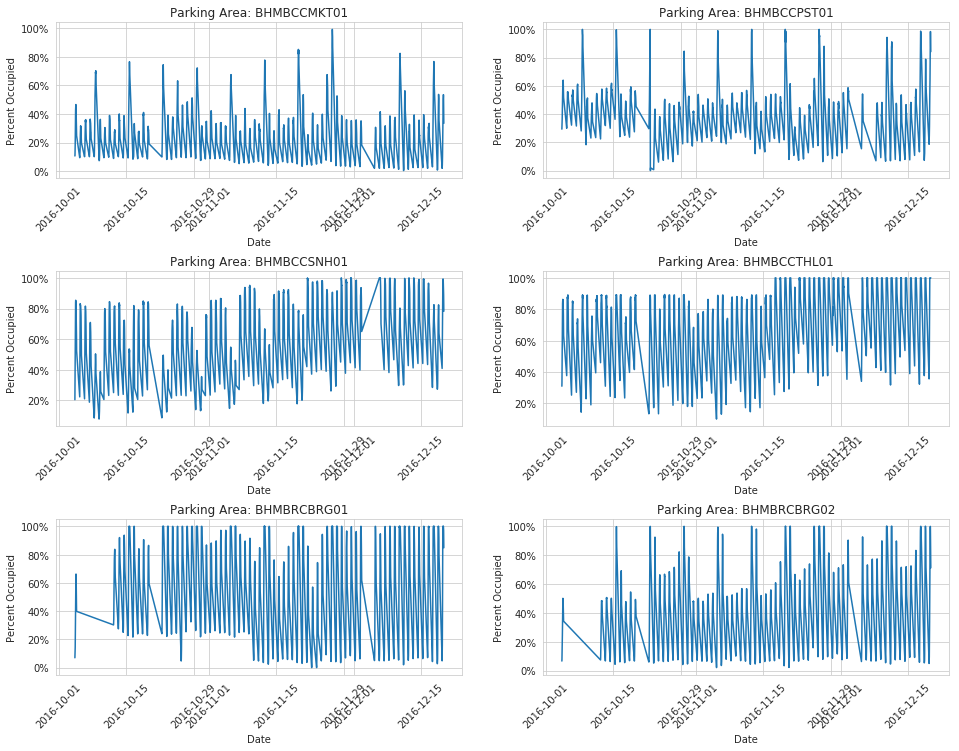

In [14]:
sample_plots_by_scn(df=df_clean, num_graphs=6, num_per_row=2)

There seems to be a pattern to the parking occupancy, which makes sense.  People may use certain parking areas more often during lunch hours if there are places to eat nearby.   Most areas will also see higher parking rates during weekdays.

In [0]:
df_agg_dthh = df_clean.groupby('date_time_halfhour').agg({'Occupancy':['sum','count'], 'Capacity':['sum','count']})
df_agg_dthh['PercentOccupied'] = df_agg_dthh.Occupancy['sum'] / df_agg_dthh.Capacity['sum']

In [16]:
# Check for times when we dont have a big enough sample
df_agg_dthh[(df_agg_dthh.Occupancy['count']<20)|(df_agg_dthh.Capacity['sum']<25000)]



Occupancy       Capacity       PercentOccupied
                          sum count      sum count                
date_time_halfhour                                                
2016-10-28 08:00:00        10     1      450     1        0.022222
2016-12-13 13:30:00       663     1      720     1        0.920833

There are two days where only one parking area was reported for a certain time.  We should replace these with more appropriate values to avoid confusing the model.  The next cell will drop these values, so they can be replaced.

In [0]:
df_agg_dthh.drop(columns=['Occupancy', 'Capacity'], inplace=True)
df_agg_dthh.drop([pd.Timestamp('2016-10-28 08:00:00'), pd.Timestamp('2016-12-13 13:30:00')], inplace=True)

In [18]:
df_agg_dthh.head()

,PercentOccupied
,
date_time_halfhour,
2016-10-04 08:00:00,0.201437
2016-10-04 08:30:00,0.247512
2016-10-04 09:00:00,0.315444
2016-10-04 09:30:00,0.382376
2016-10-04 10:00:00,0.438917


The temporary dataframe below is used to inspect for more missing times.  The ARIMA and SARIMA models will require having every time filled in.

In [19]:
temp = df_agg_dthh.reset_index()
temp['date'] = temp.date_time_halfhour.dt.date
temp['time'] = temp.date_time_halfhour.dt.time
temp = temp.groupby('date').count()
temp = pd.DataFrame(temp, index=pd.date_range('2016-10-04', '2016-12-19')).fillna(0)
temp[temp.date_time_halfhour<18]

# All of 10/20 and 10/21 are missing
# 10/30 missing 16:00 and 16:30
# 11/18 missing 9:00
# 11/25 missing 8:30
# 12/14 missing 11:00

# 10/28 and 12/13 dropped times as noted above

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


,date_time_halfhour,PercentOccupied,time
,,,
2016-10-20,0.0,0.0,0.0
2016-10-21,0.0,0.0,0.0
2016-10-28,17.0,17.0,17.0
2016-10-30,16.0,16.0,16.0
2016-11-18,17.0,17.0,17.0
2016-11-25,17.0,17.0,17.0
2016-12-03,0.0,0.0,0.0
2016-12-04,0.0,0.0,0.0
2016-12-13,17.0,17.0,17.0


This function fills in the time with the occupancy at the same time from one week earlier, based on our knowledge that people tend to do things on a weekly basis.

In [0]:
def fill_with_week_prior(df, column, year, month, day, hour, minutes):
  df.loc[pd.to_datetime(datetime.datetime(year, month, day, hour, minutes)), column] = \
      df.loc[pd.to_datetime(datetime.datetime(year, month, day, hour, minutes) + timedelta(days=-7)), column].values[0]


In [0]:
# fill in missing Percent Occupied with prior week's value for same time

# Also fill in for the under-reported times noted above

df_agg_fillmissing = df_agg_dthh.copy()


# all day loop
for hour in range(8, 17):
  for half_hour in [0, 30]:
    fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 20, hour, half_hour)
    fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 21, hour, half_hour)
    fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 12, 3, hour, half_hour)
    fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 12, 4, hour, half_hour)

# fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 20, 8, 0)
# fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 21, 8, 0)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 30, 16, 0)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 30, 16, 30)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 11, 18, 9, 0)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 11, 25, 8, 30)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 12, 14, 11, 0)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 28, 8, 0)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 12, 13, 13, 30)

df_agg_fillmissing.sort_index(inplace=True)

Now we check to make sure that there are 18 times for each day.  The following code should return an empty series.

In [22]:

temp = pd.Series(df_agg_fillmissing.index.date).value_counts()
temp[temp<18]

Series([], dtype: int64)

Let's take another look to see that we don't have any more gaps in the data.

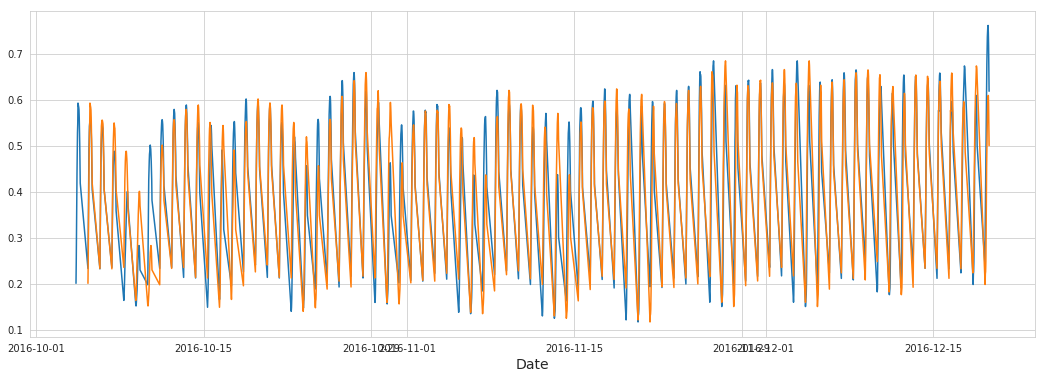

In [23]:
plt.figure(figsize=(18,6))
plt.plot(df_agg_fillmissing)
plt.plot(df_agg_fillmissing.shift(18))
plt.xlabel('Date', fontsize=14);

# Look for Seasonality and Test for Stationarity

The function below graphs a plot of autocorrelation and partial correlation.  These graphs plot the correlation between the occupancy and that same measure X periods before (ACF is the single lag value, PACF is the moving average).

From the ACF graph, we can see the pattern of the movement through the day.  Each day has 18 periods for each half hour from (8:00am - 4:30pm).  The ACF peaks at 18, signifying that the period repeats daily.  We can see another peak at 36.

We can see from the PACF that the each time is positively correlated with the previous half hour.  We can see that the pattern restarts negatively at the 19th period, which is one entire day later.

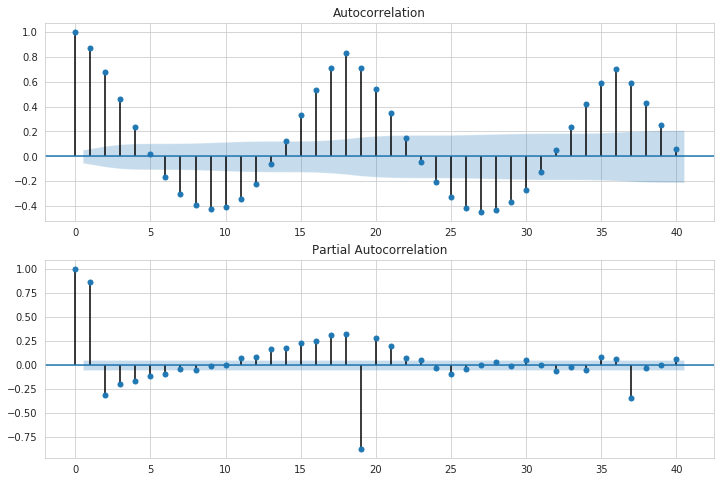

In [24]:
subplots_acf_pacf(df_agg_fillmissing)

One necessity for time series is to have stationarity.  This means that the mean and standard deviation in the endogenous variable are stable through time.

In order to achieve stationarity, we must remove the patterns in the data.

To start with, we know that the pattern repeats every 18 periods, so we use that as the period in the function below.

The Dickey-Fuller test is used to test for stationarity.  As shown below, the stationarity condition is met when using 18 periods, but we can probably do better.

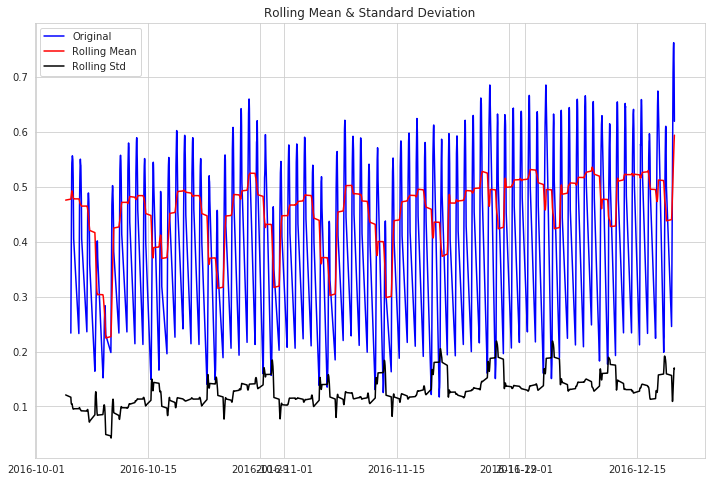

Results of Dickey-Fuller Test:
Test Statistic                   -4.028499
p-value                           0.001268
#Lags Used                       24.000000
Number of Observations Used    1361.000000
Critical Value (1%)              -3.435164
Critical Value (5%)              -2.863666
Critical Value (10%)             -2.567902
dtype: float64


In [25]:
test_stationarity(df_agg_fillmissing.squeeze(), 18)

To try to make the data more stationary, the difference below aim to make the endogenous variable the change in occupancy for each time between each day.  It then uses a period of 7 to compare each of those differences each week.

The resulting data is very stationary.  The p-value (which is essentially the probability of seeing this stationarity by random chance) is incredibly low.

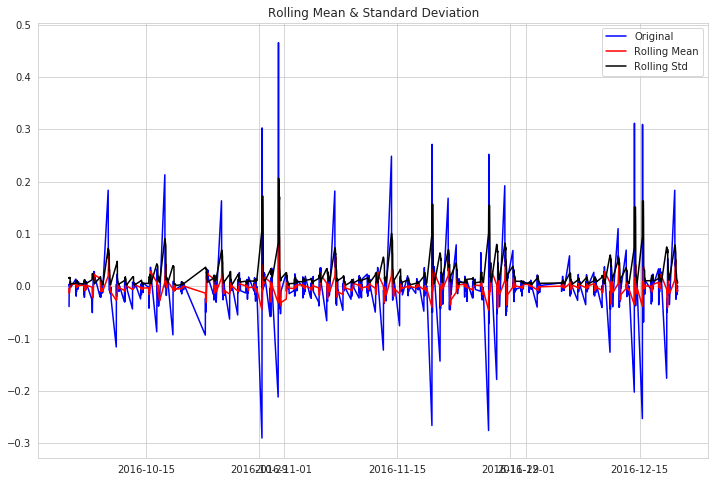

Results of Dickey-Fuller Test:
Test Statistic                -1.407532e+01
p-value                        2.891728e-26
#Lags Used                     1.900000e+01
Number of Observations Used    1.268000e+03
Critical Value (1%)           -3.435518e+00
Critical Value (5%)           -2.863822e+00
Critical Value (10%)          -2.567985e+00
dtype: float64


In [26]:
test_stationarity(df_agg_dthh.diff(18).diff().dropna().squeeze(), 7)

# Split data to train and test the Models

The train-test split used in this case is a TimeSeriesSplit, which uses a cutoff date.  All data prior to that date is training, and everything after is testing.

In [27]:
# Train-Test Split
# Sklearn built in split for time series

from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
print(tscv)


data_use = df_agg_fillmissing.reset_index()['PercentOccupied']

for train_index, test_index in tscv.split(data_use):
  train = data_use[train_index]
  test = data_use[test_index]


TimeSeriesSplit(max_train_size=None, n_splits=5)


We can check that the time split worked properly by making sure that the end of the training data lines up with the beginning of the test data.

In [28]:
train.index = df_agg_fillmissing.index[:len(train)]
train.tail()

date_time_halfhour
2016-12-06 16:00:00    0.505548
2016-12-06 16:30:00    0.458811
2016-12-07 08:00:00    0.212089
2016-12-07 08:30:00    0.256110
2016-12-07 09:00:00    0.310685
Name: PercentOccupied, dtype: float64

In [29]:
test.index = df_agg_fillmissing.index[len(train):]
test.head()

date_time_halfhour
2016-12-07 09:30:00    0.368854
2016-12-07 10:00:00    0.438171
2016-12-07 10:30:00    0.494762
2016-12-07 11:00:00    0.557329
2016-12-07 11:30:00    0.589452
Name: PercentOccupied, dtype: float64

# ARIMA Model

Based on our ACF and PACF, we will first try a baseline ARIMA model that uses 18 periods and a first order difference.  The ARIMA model with a period of 18 takes a while to run (about 6 minutes on google colab).

In [30]:
%%time
# Define and fit ARIMA model
arima_model = ARIMA(train, order=(18, 1, 0))
results_AR = arima_model.fit(disp=-1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


CPU times: user 4min 23s, sys: 1min 34s, total: 5min 57s
Wall time: 3min 2s


Let's take a look at how the forecasted occupancy rates (purple) compare to the actual rates (orange).  The rates in blue are those that were used to train the model.

The function also shows several metrics on how well the function performed.
* Explained Variance - the amount of variance in the occupancy rates explained by the model (~77%)
* Mean Absolute Error (MAE) - the average percent error in the predictions (~5.5%)


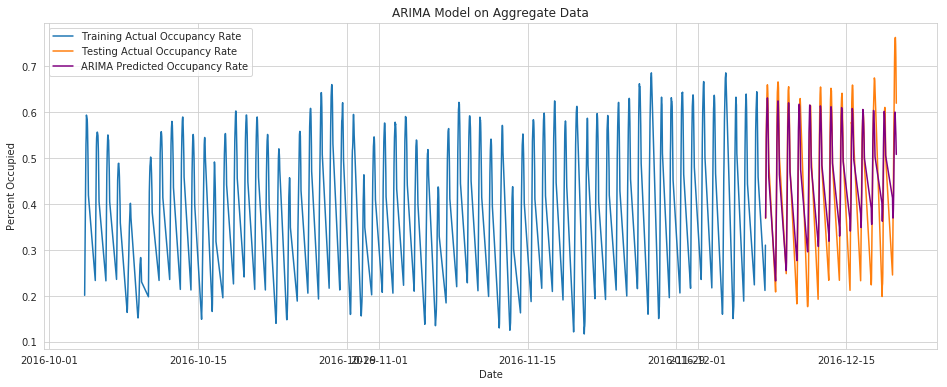

-----------------------------------------------------------------------------
ARIMA Model Metrics on Test Data
Explained Variance:
	 0.7690813638663216
MAE:
	 0.05530672421729186


In [31]:
plt.figure(figsize=(16,6))
plt.title('ARIMA Model on Aggregate Data')
plt.plot(train, label='Training Actual Occupancy Rate')
plt.xlabel('Date')
plt.ylabel('Percent Occupied')
y_pred_AR = pd.Series(results_AR.forecast(steps=len(test))[0], index=test.index)
plt.plot(test, label='Testing Actual Occupancy Rate')
plt.plot(y_pred_AR, color='purple', label='ARIMA Predicted Occupancy Rate')
plt.legend()

plt.show()


print('-'*77)
print('ARIMA Model Metrics on Test Data')
print('='*77)
report_metrics(test.squeeze(), y_pred_AR.squeeze())

# SARIMA Model

The model below reflects the seasonality of the occupancy rates.  The difference here is that a seasonal order is applied such that the 18 period-day is reflected.

This model is able to run much more quickly (about 30 seconds on google colab).

In [32]:
%%time
# Define and fit SARIMA model
my_seasonal_order = (1, 1, 1, 18)
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=my_seasonal_order)
results_SAR = sarima_model.fit(disp=-1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


CPU times: user 21 s, sys: 13.3 s, total: 34.3 s
Wall time: 17.5 s


We can see that the model seems to fit the actual data much more closely.  The metrics also show this:
* Explained Variance - increased to 85.8%
* Mean Absolute Error - decreased to 4.9%

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


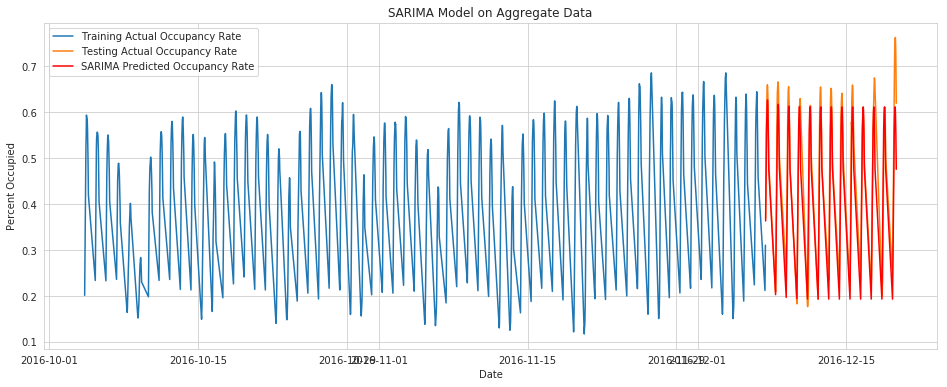

-----------------------------------------------------------------------------
SARIMA Model Metrics on Test Data
Explained Variance:
	 0.8579497936600348
MAE:
	 0.04914439301573438


In [33]:
plt.figure(figsize=(16,6))
plt.title('SARIMA Model on Aggregate Data')
plt.plot(train, label='Training Actual Occupancy Rate')
plt.xlabel('Date')
plt.ylabel('Percent Occupied')
y_pred_sar = pd.Series(results_SAR.forecast(steps=len(test)).values, index=test.index)
plt.plot(test, label='Testing Actual Occupancy Rate')
plt.plot(y_pred_sar, color='red', label='SARIMA Predicted Occupancy Rate')
plt.legend()

plt.show()


print('-'*77)
print('SARIMA Model Metrics on Test Data')
print('='*77)
report_metrics(test.squeeze(), y_pred_sar.squeeze())

# Model Comparison

We can take a look at how the actual predicted occupancy rates compare in the pandas dataframe below.

In [34]:
df_SAR_results = pd.DataFrame(list(zip(test.index, y_pred_sar, test, y_pred_sar-test)), columns=['Date_Time', 'Predicted', 'Actual', 'Difference'])
df_SAR_results['Absolute_Diff'] = np.abs(df_SAR_results.Difference)
df_SAR_results.sort_values('Absolute_Diff', ascending=False)

,Date_Time,Predicted,Actual,Difference,Absolute_Diff
74,2016-12-11 10:30:00,0.440147,0.266308,0.173839,0.173839
194,2016-12-17 16:30:00,0.475947,0.647990,-0.172043,0.172043
73,2016-12-11 10:00:00,0.388501,0.219690,0.168811,0.168811
227,2016-12-19 15:00:00,0.580498,0.746696,-0.166198,0.166198
228,2016-12-19 15:30:00,0.554546,0.718909,-0.164363,0.164363
226,2016-12-19 14:30:00,0.602365,0.762891,-0.160527,0.160527
225,2016-12-19 14:00:00,0.611695,0.761781,-0.150086,0.150086
229,2016-12-19 16:00:00,0.519877,0.667912,-0.148036,0.148036
193,2016-12-17 16:00:00,0.519877,0.667002,-0.147125,0.147125
230,2016-12-19 16:30:00,0.475947,0.619624,-0.143677,0.143677


This plot zooms in on the testing period and has the predictions from both models.  We can see that the SARIMA model fits much more closely to reality.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


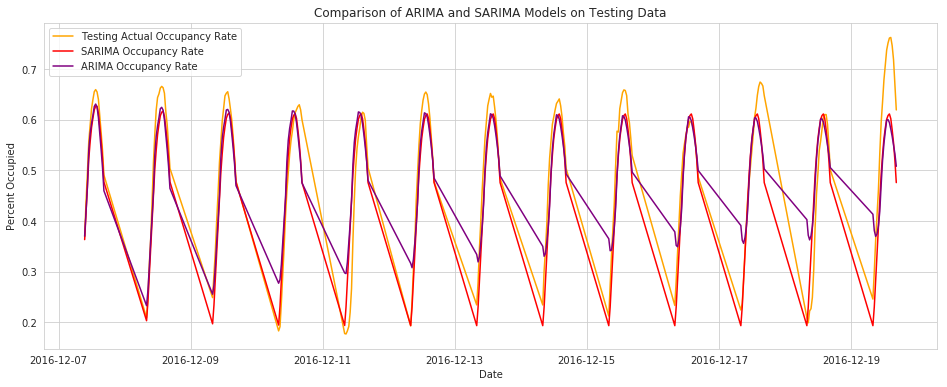

In [35]:
plt.figure(figsize=(16,6))
plt.title('Comparison of ARIMA and SARIMA Models on Testing Data')
plt.xlabel('Date')
plt.ylabel('Percent Occupied')
y_pred_sar = pd.Series(results_SAR.forecast(steps=len(test)).values, index=test.index)
plt.plot(test, label='Testing Actual Occupancy Rate', color='orange')
plt.plot(y_pred_sar, color='red', label='SARIMA Occupancy Rate')

y_pred_AR = pd.Series(results_AR.forecast(steps=len(test))[0], index=test.index)
plt.plot(y_pred_AR, color='purple', label='ARIMA Occupancy Rate')

plt.legend()

plt.show()

